# v3

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import layers, models, regularizers

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Function to select a specific number of images from each class
def select_images_per_class(images, labels, num_images_per_class):
    selected_indices = []
    for i in range(10):  # Assuming 10 classes in MNIST
        class_indices = np.where(labels == i)[0]
        selected_indices.extend(np.random.choice(class_indices, num_images_per_class, replace=False))
    return images[selected_indices], labels[selected_indices], selected_indices

# Select 10 images from each class for training
num_images_per_class = 10
x_labeled, y_labeled, labeled_indices = select_images_per_class(x_train, y_train, num_images_per_class)

# Set the rest of the training data as unlabeled
x_unlabeled = np.delete(x_train, labeled_indices, axis=0)

# Print the shapes of the labeled and unlabeled datasets
print("Labeled Data Shape:", x_labeled.shape)
print("Unlabeled Data Shape:", x_unlabeled.shape)


Labeled Data Shape: (100, 28, 28)
Unlabeled Data Shape: (59900, 28, 28)


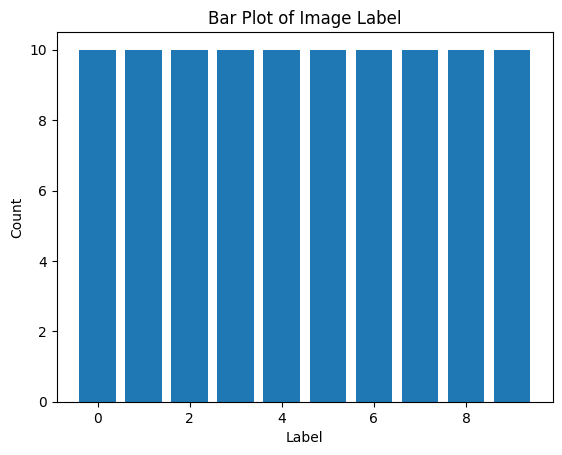

In [11]:
import matplotlib.pyplot as plt

a,b = np.unique(y_labeled, return_counts=True)
# Plotting the bar plot
plt.bar(a, b)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Plot of Image Label')
plt.show()

In [53]:
# Function to generate rotated images
def generate_rotated_images(images, angles):
    rotated_images = []
    for image, angle in zip(images, angles):
        # Add an extra dimension to the image
        image = np.expand_dims(image, axis=-1)
        rotated = tf.image.rot90(image, k=angle // 90)
        rotated_images.append(rotated.numpy())
    return np.array(rotated_images)

# Generate random rotation angles for each image with balanced classes
rotation_angles_train = np.concatenate([
    np.random.choice([0], size=len(x_unlabeled)//6),
    np.random.choice([60], size=len(x_unlabeled)//6),
    np.random.choice([120], size=len(x_unlabeled)//6),
    np.random.choice([180], size=len(x_unlabeled)//6),
    np.random.choice([240], size=len(x_unlabeled)//6),
    np.random.choice([300], size=len(x_unlabeled)//6)
])

rotation_angles_test = np.concatenate([
    np.random.choice([0], size=len(x_test)//6),
    np.random.choice([60], size=len(x_test)//6),
    np.random.choice([120], size=len(x_test)//6),
    np.random.choice([180], size=len(x_test)//6),
    np.random.choice([240], size=len(x_test)//6),
    np.random.choice([300], size=len(x_test)//6)
])

# Shuffle the rotation angles to ensure randomness
np.random.shuffle(rotation_angles_train)
np.random.shuffle(rotation_angles_test)

# Rotate the images
x_train_rotated = generate_rotated_images(x_unlabeled, rotation_angles_train)
x_test_rotated = generate_rotated_images(x_test, rotation_angles_test)

# Reshape and normalize the images
x_train_rotated = x_train_rotated.reshape(x_train_rotated.shape[0], 28, 28, 1).astype('float32') / 255
x_test_rotated = x_test_rotated.reshape(x_test_rotated.shape[0], 28, 28, 1).astype('float32') / 255

# Convert the target variable to categorical
y_train_rotated = to_categorical(rotation_angles_train // 90, num_classes=6)
y_test_rotated = to_categorical(rotation_angles_test // 90, num_classes=6)

In [13]:
# Define the model
rotation_model  = Sequential()
rotation_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
rotation_model.add(MaxPooling2D(pool_size=(2, 2)))
rotation_model.add(Conv2D(64, (3, 3), activation='relu'))
rotation_model.add(MaxPooling2D(pool_size=(2, 2)))
rotation_model.add(Flatten())
rotation_model.add(Dense(128, activation='relu'))
rotation_model.add(Dense(6, activation='softmax'))

# Compile the model
rotation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
rotation_model.fit(x_train_rotated, y_train_rotated, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
accuracy = rotation_model.evaluate(x_test_rotated, y_test_rotated)[1]
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
749/749 [==============================] - 5s 5ms/step - loss: 0.1689 - accuracy: 0.9419 - val_loss: 0.0928 - val_accuracy: 0.9665
Epoch 2/10
749/749 [==============================] - 4s 5ms/step - loss: 0.0632 - accuracy: 0.9786 - val_loss: 0.0509 - val_accuracy: 0.9823
Epoch 3/10
749/749 [==============================] - 4s 6ms/step - loss: 0.0510 - accuracy: 0.9822 - val_loss: 0.0516 - val_accuracy: 0.9804
Epoch 4/10
749/749 [==============================] - 4s 5ms/step - loss: 0.0414 - accuracy: 0.9852 - val_loss: 0.0370 - val_accuracy: 0.9864
Epoch 5/10
749/749 [==============================] - 4s 5ms/step - loss: 0.0362 - accuracy: 0.9869 - val_loss: 0.0368 - val_accuracy: 0.9874
Epoch 6/10
749/749 [==============================] - 4s 5ms/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 0.0296 - val_accuracy: 0.9894
Epoch 7/10
749/749 [==============================] - 4s 5ms/step - loss: 0.0272 - accuracy: 0.9901 - val_loss: 0.0361 - val_accuracy: 0.9881
Epoch 

In [32]:
# Create a new model without the output layer of the rotation_mode
base_model = Sequential(rotation_model.layers[:-1])

# Add new layers for the 10-label classification task
fine_tuned_model = Sequential()
fine_tuned_model.add(base_model)
fine_tuned_model.add(Dense(128, activation='relu'))
fine_tuned_model.add(Dropout(0.5))
fine_tuned_model.add(Dense(64, activation='relu'))
fine_tuned_model.add(Dropout(0.2))
fine_tuned_model.add(Dense(10, activation='softmax'))

fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model on the labeled images
fine_tuned_model.fit(x_labeled.reshape((len(x_labeled), 28, 28, 1)).astype('float32') / 255, y_labeled, epochs=20)

# Evaluate the fine-tuned model on the test set
test_images = x_test.reshape((len(x_test), 28, 28, 1)).astype('float32') / 255
test_loss, test_acc = fine_tuned_model.evaluate(test_images, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
4/4 [==============================] - 2s 7ms/step - loss: 4.4937 - accuracy: 0.0900
Epoch 2/20
4/4 [==============================] - 0s 5ms/step - loss: 3.0405 - accuracy: 0.1800
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 1.9904 - accuracy: 0.2900
Epoch 4/20
4/4 [==============================] - 0s 7ms/step - loss: 1.6906 - accuracy: 0.4700
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 1.2541 - accuracy: 0.6100
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 1.2113 - accuracy: 0.6300
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.9667 - accuracy: 0.7700
Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8760 - accuracy: 0.7800
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7004 - accuracy: 0.8000
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 0.4753 - accuracy: 0.9000
Epoch 11/20
4/4 [======================

313/313 [==============================] - 1s 2ms/step


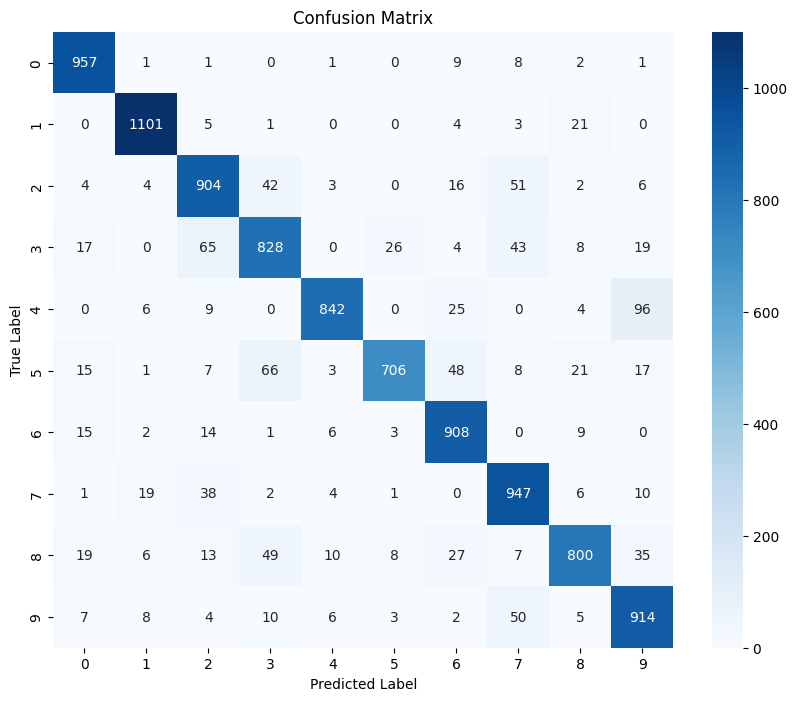

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import datasets

y_pred = np.argmax(fine_tuned_model.predict(x_test.reshape((len(x_test), 28, 28, 1)).astype('float32') / 255), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming y_true and y_pred are your true labels and predicted labels, respectively
# Replace these with your actual test set labels and predictions
y_true = y_test
y_pred = np.argmax(fine_tuned_model.predict(x_test.reshape((len(x_test), 28, 28, 1)).astype('float32') / 255), axis=1)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))


313/313 [==============================] - 1s 2ms/step
Accuracy: 89.07%
Precision: 89.33%
Recall: 89.07%
F1 Score: 89.03%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.85      0.88      0.86      1032
           3       0.83      0.82      0.82      1010
           4       0.96      0.86      0.91       982
           5       0.95      0.79      0.86       892
           6       0.87      0.95      0.91       958
           7       0.85      0.92      0.88      1028
           8       0.91      0.82      0.86       974
           9       0.83      0.91      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

